### 01d_graph_creation_and_attributes — Building a NetworkX Graph

### What this step does
This notebook introduces the fundamentals of **NetworkX**. It begins by creating a **synthetic dataset** of nodes (e.g., facilities) and edges (e.g., travel routes with times) to ensure reproducibility. It then demonstrates how to load this tabular data into a NetworkX graph, assigning attributes to both nodes and edges. The final graph is visualised and saved for use in subsequent notebooks.

### Why this is useful
- Establishes a foundational workflow for creating graphs from CSV files.
- Demonstrates how to enrich nodes and edges with critical metadata (attributes).
- Provides a self-contained, shareable starting point for graph analysis without external data dependencies.
- Creates a baseline `graph.graphml` file for the next steps in the series.

### Inputs (Created by this notebook)
- `data/synthetic/synthetic_nodes.csv`
- `data/synthetic/synthetic_edges.csv`

### Outputs (Created by this notebook)
- `outputs/01d_graph_creation/graph.graphml`
- `outputs/01d_graph_creation/01d_summary.json`
- `outputs/01d_graph_creation/01d_graph_visualisation.png`

### Key operations
- Generate synthetic node and edge data using `pandas` and `numpy`.
- Define single-purpose functions for loading data and building the graph.
- Create a `networkx.Graph` object.
- Add nodes with `kind`, `name`, and `pos` (position) attributes.
- Add edges with `weight` (travel time) attributes.
- Perform a basic visualisation using `matplotlib`.
- Save the graph to a GraphML file for persistence.

In [1]:
# --- Step 0: Imports and Configuration ---
# 203 # This cell imports all necessary libraries for the notebook.
# 203 # It follows your established style by separating standard library imports,
# 203 # third-party imports, and setting up display preferences.
# 203 # We use pathlib for robust path management and a simple Config class
# 203 # to hold key file paths and parameters, ensuring clarity and ease of modification.

from __future__ import annotations

import json
import random
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

# 203 # Display preferences for pandas DataFrames for better readability.
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# 203 # Configuration dataclass to hold all file paths and settings.
# 203 # This makes the notebook's dependencies explicit and easy to manage.
@dataclass(frozen=True)
class Config:
    """Configuration object for file paths and parameters."""
    data_dir: Path
    output_dir: Path
    nodes_file: Path
    edges_file: Path
    graph_file: Path
    viz_file: Path
    summary_file: Path
    num_nodes: int = 25
    num_edges_factor: float = 1.5


# 203 # Function to set up the configuration and create necessary directories.
# 203 # This is a single-role function dedicated to setup.
def setup_config() -> Config:
    """Initialises configuration and creates directories."""
    root_dir = Path(".")
    data_dir = root_dir / "data" / "synthetic"
    output_dir = root_dir / "outputs" / "01d_graph_creation"

    # 203 # Create directories if they don't exist.
    data_dir.mkdir(parents=True, exist_ok=True)
    output_dir.mkdir(parents=True, exist_ok=True)

    return Config(
        data_dir=data_dir,
        output_dir=output_dir,
        nodes_file=data_dir / "synthetic_nodes.csv",
        edges_file=data_dir / "synthetic_edges.csv",
        graph_file=output_dir / "graph.graphml",
        viz_file=output_dir / "01d_graph_visualisation.png",
        summary_file=output_dir / "01d_summary.json",
    )

cfg = setup_config()

print("--- Configuration Initialised ---")
print(f"Synthetic data will be saved to: {cfg.data_dir}")
print(f"Outputs will be saved to: {cfg.output_dir}")

--- Configuration Initialised ---
Synthetic data will be saved to: data/synthetic
Outputs will be saved to: outputs/01d_graph_creation


In [2]:
# --- Step 1: Generate Synthetic Data ---
# 203 # This cell contains functions to create synthetic node and edge data.
# 203 # Each function has a single responsibility: one for nodes, one for edges.
# 203 # This mirrors the data preparation steps in your notebooks, providing
# 203 # a clean, reproducible dataset for the graph analysis series.

def create_synthetic_nodes(num_nodes: int, file_path: Path) -> pd.DataFrame:
    """Generates a DataFrame of synthetic nodes and saves it to a CSV file."""
    # 203 # Define node types and their proportional representation.
    node_kinds = ["Clinic", "Hospital", "Warehouse"]
    node_ids = [f"N{i:03d}" for i in range(num_nodes)]
    kinds = random.choices(node_kinds, weights=[0.6, 0.2, 0.2], k=num_nodes)
    names = [f"{k}-{i:03d}" for i, k in enumerate(kinds)]

    # 203 # Generate random coordinates for visualization.
    np.random.seed(42)
    x_coords = np.random.rand(num_nodes) * 100
    y_coords = np.random.rand(num_nodes) * 100

    nodes_df = pd.DataFrame({
        "node_id": node_ids,
        "name": names,
        "kind": kinds,
        "x_pos": x_coords,
        "y_pos": y_coords,
    })

    nodes_df.to_csv(file_path, index=False)
    print(f"Generated {len(nodes_df)} nodes and saved to {file_path}")
    return nodes_df


def create_synthetic_edges(nodes_df: pd.DataFrame, factor: float, file_path: Path) -> pd.DataFrame:
    """Generates a DataFrame of synthetic edges based on nodes and saves it."""
    num_edges = int(len(nodes_df) * factor)
    node_ids = nodes_df["node_id"].tolist()
    edges = set()

    # 203 # Create random connections, ensuring no self-loops or duplicate edges.
    while len(edges) < num_edges:
        u, v = random.sample(node_ids, 2)
        # 203 # Ensure edge is unique regardless of direction for an undirected graph.
        edge = tuple(sorted((u, v)))
        edges.add(edge)

    # 203 # Assign a random weight (e.g., travel time) to each edge.
    edge_list = [(*edge, round(random.uniform(5, 60))) for edge in edges]

    edges_df = pd.DataFrame(edge_list, columns=["source", "target", "travel_time"])

    edges_df.to_csv(file_path, index=False)
    print(f"Generated {len(edges_df)} edges and saved to {file_path}")
    return edges_df


# 203 # Execute the data generation functions.
nodes_df = create_synthetic_nodes(cfg.num_nodes, cfg.nodes_file)
edges_df = create_synthetic_edges(nodes_df, cfg.num_edges_factor, cfg.edges_file)

Generated 25 nodes and saved to data/synthetic/synthetic_nodes.csv
Generated 37 edges and saved to data/synthetic/synthetic_edges.csv


In [4]:
# --- Step 2: Load Data and Construct Graph ---
# 203 # This cell defines functions to load the previously generated data
# 203 # and construct a NetworkX graph. The design separates data loading
# 203 # from graph construction, following your single-role function principle.
# 203 # Attributes from the DataFrames are attached to nodes and edges here.

def load_data(nodes_path: Path, edges_path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Loads node and edge CSV files into pandas DataFrames."""
    nodes = pd.read_csv(nodes_path)
    edges = pd.read_csv(edges_path)
    print("Successfully loaded node and edge data.")
    return nodes, edges


def build_graph(nodes_df: pd.DataFrame, edges_df: pd.DataFrame) -> nx.Graph:
    """Builds a NetworkX graph from node and edge DataFrames."""
    G = nx.Graph()

    # 203 # Add nodes with their attributes.
    # 203 # We iterate through the DataFrame rows to add each node and its data.
    for _, row in nodes_df.iterrows():
        G.add_node(
            row['node_id'],
            name=row['name'],
            kind=row['kind'],
            pos=(row['x_pos'], row['y_pos'])
        )

    # 203 # Add edges with their attributes (weight).
    # 203 # We use a list comprehension for efficient edge and attribute creation.
    edge_data = [
        (row['source'], row['target'], {'weight': row['travel_time']})
        for _, row in edges_df.iterrows()
    ]
    G.add_edges_from(edge_data)

    print("NetworkX graph constructed successfully.")
    print(f"- Nodes: {G.number_of_nodes()}")
    print(f"- Edges: {G.number_of_edges()}")
    return G


# 203 # Execute the loading and graph building process.
nodes, edges = load_data(cfg.nodes_file, cfg.edges_file)
G = build_graph(nodes, edges)

Successfully loaded node and edge data.
NetworkX graph constructed successfully.
- Nodes: 25
- Edges: 37


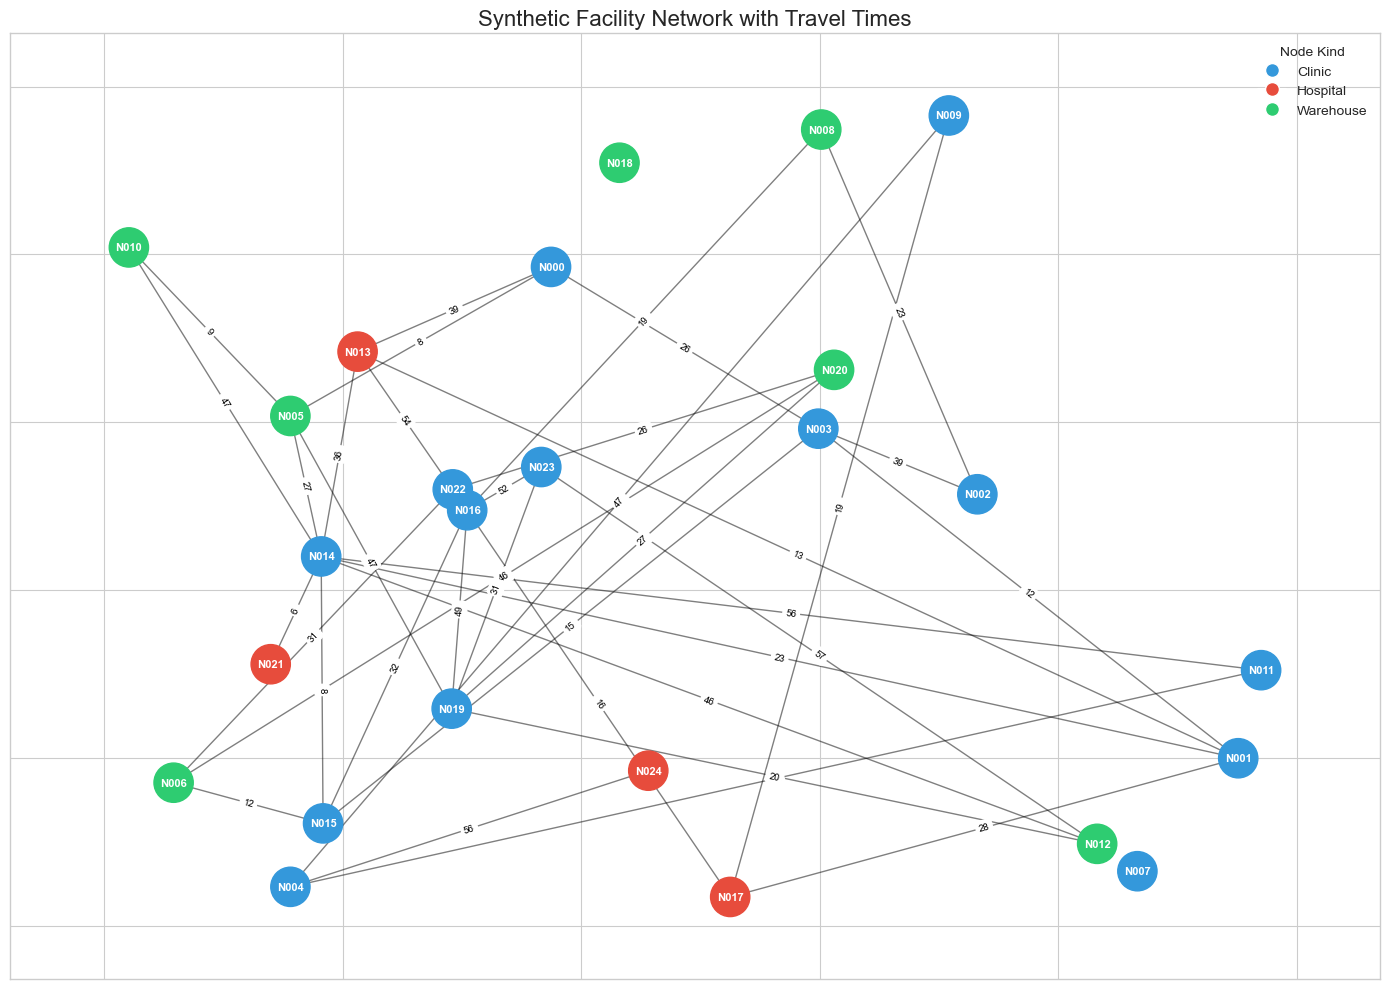

Graph visualisation saved to outputs/01d_graph_creation/01d_graph_visualisation.png


In [5]:
# --- Step 3: Basic Graph Visualization ---
# 203 # This cell visualises the newly created graph.
# 203 # It demonstrates how to use node attributes (kind, position) to create
# 203 # a more informative and aesthetically pleasing plot.
# 203 # Edge weights are also displayed as labels.

def visualize_graph(G: nx.Graph, file_path: Path):
    """Creates and saves a visualisation of the graph."""
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 10))

    # 203 # Extract attributes for plotting.
    pos = nx.get_node_attributes(G, 'pos')
    kinds = nx.get_node_attributes(G, 'kind')
    edge_weights = nx.get_edge_attributes(G, 'weight')

    # 203 # Define colors for each node kind for clear visual distinction.
    color_map = {'Clinic': '#3498db', 'Hospital': '#e74c3c', 'Warehouse': '#2ecc71'}
    node_colors = [color_map.get(kinds.get(node, ''), '#bdc3c7') for node in G.nodes()]

    # 203 # Draw the network components.
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_color='white', font_weight='bold', ax=ax)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=7, ax=ax)

    # 203 # Create a legend for the node kinds.
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=kind, 
                   markerfacecolor=color, markersize=10) 
        for kind, color in color_map.items()
    ]
    ax.legend(handles=legend_elements, title="Node Kind", loc="upper right")

    ax.set_title("Synthetic Facility Network with Travel Times", fontsize=16)
    plt.tight_layout()
    fig.savefig(file_path, dpi=200)
    plt.show()
    print(f"Graph visualisation saved to {file_path}")

# 203 # Execute the visualisation function.
visualize_graph(G, cfg.viz_file)

In [8]:
# --- Step 4: Export Graph and Summary ---
# 203 # This final cell saves the constructed graph to a GraphML file.
# 203 # This format preserves all node and edge attributes and is ideal for
# 203 # interoperability and for loading the graph in subsequent notebooks.
# 203 # A JSON summary file is also created for quick reference.

def export_artifacts(G: nx.Graph, graph_path: Path, summary_path: Path):
    """Saves the graph to GraphML and creates a summary JSON file."""
    # 203 # Convert tuple attributes to strings for GraphML compatibility.
    # 203 # The 'pos' attribute is a tuple (x, y), which is not a valid GraphML data type.
    # 203 # This is done in-place before writing the file.
    for node, data in G.nodes(data=True):
        if 'pos' in data and isinstance(data['pos'], tuple):
            data['pos'] = str(data['pos'])

    # 203 # Save the graph to GraphML format.
    nx.write_graphml(G, graph_path)
    print(f"Graph saved to {graph_path}")

    # 203 # Create and save a summary dictionary.
    summary = {
        "notebook": "01d_graph_creation_and_attributes",
    }

# 203 # Execute the export function.
export_artifacts(G, cfg.graph_file, cfg.summary_file)





Graph saved to outputs/01d_graph_creation/graph.graphml
